## CM50268 / CM30322

## Coursework 2

# Stochastic Approximation & Bayesian Modelling in Practice

**Total Marks 70 (70% of overall unit grade).**

*Submission deadline: 8pm, Tuesday 29th April. Please submit all your files in Moodle.*

**This coursework is split into three parts.** For convenience, each part has its own Jupyter Notebook - **your submission should include all three, plus any other requested materials.**

- **Part 2A:** Developing sampling algorithms, Importance and Metropolis (25 marks)
- **Part 2B:** Using HMC with NUTS (from `numpyro`), for state-of-the-art inference (15 marks)
- **Part 2C:** Applying Bayesian libraries to a practical hierarchical modelling problem (30 marks)

## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code.
Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`

Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**.
The workbook you submit must be an `.ipynb` file, which is saved into the
directory you're running Jupyter; alternatively you can download it from the menu above using
`File -> Download`. Remember to save your work regularly
("Save Notebook" in the File menu, the icon of a floppy disk, or Ctrl-S);
the version you submit should have all code blocks showing the results (if any)
of execution below them.

### Important!

**You should take care to avoid any suggestion of plagiarism in your submission.**
There is helpful information on "Academic Integrity" and, specifically, how to avoid plagiarism
on the University website: https://www.bath.ac.uk/library/help/infoguides/plagiarism.html

For this coursework, **you may use library code from specific sources only**:
- `numpy`, `scipy`, `matplotlib` and `seaborn` for the core programming and visualisation,
- `numpyro`, `arviz` for the real-world MCMC application in Parts 2B and 2C.

That said, if you wish to use any alternative libraries, you are welcome to request this via the *Moodle* discussion forum.

Note that **the use of Generative AI is not permitted**.

# Coursework 2A: Implementing Stochastic Approximation

Coursework Part 2A focuses on implementing Monte Carlo sampling for computing useful expectations in the Bayesian linear regression model, using concepts and methodology covered in Lectures 6&ndash;8. Primarily it involves the implementation of *importance sampling* and the *Metropolis algorithm* (a variant of MCMC). It will build on some of the computations undertaken in Coursework One.

The data studied will be synthetic (generated from randomly weighted basis functions) with additive Gaussian noise of standard deviation $\sigma$. The data is to be modelled with the usual Bayesian linear (in-the-parameters) model, adopting a Gaussian weight prior with hyperparameter $\alpha$, and with Gaussian "RBF" basis functions of unspecified width/radius/length-scale $r$. The primary aims of the lab are to estimate $\alpha$, $r$ and, later, the data noise $\sigma$.

There are three principal tasks (detailed below), with varying marks. In summary here:

**Task 1:** Compute and visualise the form of the posterior over hyperparameter $\alpha$ and basis function width $r$ (5 marks)

**Task 2:** Implement the importance sampling procedure to estimate the posterior mean width parameter $r$ for the Gaussian "RBF" basis functions in the linear model (given known noise $\sigma^2$). This will involve experimenting with different proposal distributions, and comparing convergence (8 marks)

**Task 3:** Implement the Metropolis MCMC algorithm to estimate the basis length-scale $r$, again for different proposals. Extend this to estimation of $\sigma^2$, and ultimately to model weights $\mathbf{w}$, thereby computing a mean predictor (12 marks)


### "Advanced" Marks
**Please note!** Across assignments, there may be a small number of marks which are designated "advanced" marks.
These apply to sub-tasks which might be a little more technically demanding, and can optionally be skipped without interrupting the "flow" of an assignment. There are 3 advanced marks (out of 25) in Coursework 2A.

## Setup

### Support code

To get started, the code cell below imports the requisite standard modules, plus a setup module `setup_cw2` specific to this coursework.
It is imported as `setup`. This module contains:
- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian RBF basis matrices $\Phi$ of varying order,
- a basic function `plot_regression` for graphing predictors (again, you may choose to use your own).

### Important!
You will need to import your specimen functions `compute_posterior` and `compute_log_marginal` as implemented for Coursework One. Feel free to paste these into the `setup_cw2.py` file or just include your own separate import.


In [8]:
##
## Setup
##
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Lab-specific support module
import setup_cw2 as setup


We also set some "constants" here: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.2$ for the entire exercise. Mainly we will assume it is known for modelling purposes, although in Task 3c we will estimate it.

The centres (locations) of the basis functions are fixed here (the length scale, or width, $r$ of those basis functions will be varied during the exercise).


In [10]:
#
# Setup
#
# Define some fixed values
#
# Parameters that determine the generated data
#
sigma = 0.2  # Standard deviation
sigma_2 = sigma ** 2  # Variance
radius_gen = 1.00  # Generative basis radius or width
#
N_train = 50
N_test = 1000

### Generate Data
We synthesise two data sets:
- a training set of size $N=50$ with added noise of std. dev. $\sigma=0.20$
- a test set of size $N=1000$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0, 10]$.

### Generate Basis
For our linear (in-the-parameters) model, we utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. Each basis function has its own center $c_m$; these are equally spaced and will remain fixed. The length scale, or width, $r$ is common across basis functions, and will be varied. There are $N-1$ (49) basis functions, plus a fixed bias.

### Example Model Fit
For an arbitrarily selected set of sub-optimal values of $\alpha$, $\sigma^2$ and $r$, a simple least-squares predictor is computed and graphed below (using `plot_regresssion`) for illustrative purposes. In particular, it also demonstrates how `RBFGenerator` is used (you will need this).


N_train = 50
Empirical σ_train = 0.200
N_test = 1000


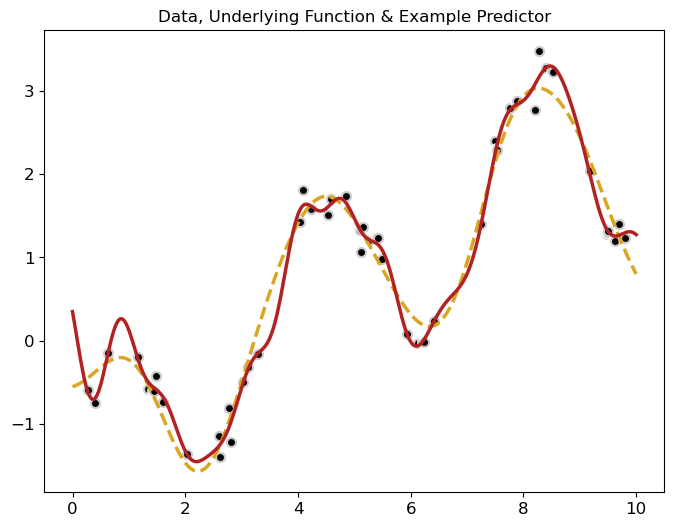

In [12]:
# Generate training data
generator = setup.DataGenerator(r=radius_gen, noise=sigma)
x_train, y_train = generator.get_data('TRAIN', N_train)
x_test, y_test = generator.get_data('TEST', N_test)

# Demonstrate use of basis
centres = np.linspace(generator.x_min, generator.x_max, N_train - 1)
radius_model = radius_gen * 0.5  # Example model uses basis functions that are too narrow
RBF = setup.RBFGenerator(centres, radius_model, bias=True)
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)

# Find quick fit for fixed guess for alpha and known s2
alph = 1e-3
w_pls = np.linalg.inv(PHI_train.T @ PHI_train + alph * np.eye(RBF.M)) @ PHI_train.T @ y_train
fy_test = PHI_test @ w_pls

# Show the training data and generating function, plus our mean fit
setup.plot_regression(x_train, y_train, x_test, y_test, fy_test)
plt.title("Data, Underlying Function & Example Predictor");

## Overall Objective

Although there are some varied exercises in this coursework, most centre around the estimation of a "good" value for the basis function width parameter $r$ given our training data.

This is not a "strictly Bayesian" objective. Ideally, of course, we would make predictions by *integrating* over $r$, but we might imagine that when our model is deployed (as can often be the case in real world applications), there won't be the opportunity to undertake any extended Bayesian computations (*e.g.* running sampling algorithms to calculate predictive distributions in real time). So we are taking a pragmatic viewpoint, and considering how we might find a single good setting for our basis function length-scale. (Exception: in the final "advanced" Task 3d, we *will* integrate over $r$.)

Our model takes the standard form of $y = \sum_m^M w_m \phi_m(x)$, a linearly-weighted sum of basis functions as defined above: $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. These basis functions have fixed locations $c_m$; but we are free to adjust the common length-scale $r$.

So we will employ our Bayesian techniques now, in the "model development" phase, to determine a good value of $r$ that might be used in any ultimate deployment. Following good Bayesian practice, we will estimate the optimal values by integrating out (averaging over) the other unknowns (the "nuisance variables"). Because most of the integrations are analytically intractable, we will need to utilise the sampling techniques introduced in Lectures 7 and 8, and this aspect is the focus of this coursework.


# Task 1: Computing & Visualising the Hyperparameter Posterior
**5 marks for this task in total.**

**Assume for now that the data noise variance $\sigma^2=0.2^2$ is a known quantity**, and for clarity we will omit it from the probability distribution notation below. We will look at estimating $\sigma^2$ later in the lab (in Task 3, using the Metropolis MCMC algorithm).


## Task 1a
*2 marks overall*

#### Compute the hyperparameter posterior (2 marks)

The first thing to do is to write a function to compute $p(\alpha, r | y)$, where $y$ is the training data (vector) `y_train`. Using Bayes' rule:

$$p(\alpha, r | y) = \frac{p(y|\alpha,r)\, p(\alpha)\, p(r)}{p(y)}$$

We cannot compute this analytically, as the denominator $p(y)$ is intractable. But to visualise its shape, we can calculate the numerator, which we typically refer to as $P^\ast(\alpha, r)$. The first term in the numerator $p(y|\alpha,r)$ is the marginal likelihood calculated in Coursework One (though note the dependence on $r$, which will change $\Phi$). The second two terms are priors for $\alpha$ and $r$. These are both *scale parameters*, so it is appropriate to use an uninformative, uniform prior, *on a log scale*. As such, *those terms can be treated as constant and ignored*, provided we work with $\log\alpha$ and $\log r$ in our sampling. So, $p(\alpha, r | y) \propto p(y|\alpha,r)$, and we only need compute the latter.

It is suggested that the log p.d.f., $\log p(\alpha, r | y)$, is computed by a function of the form: `log_prob_alph_r_given_y(alph, r, s2, x, y, centres)`. If the probability itself is required, this can be obtained by exponentiating.

This function will need to create a new `RBFGenerator` object and recompute the basis matrix (as this changes with $r$), then call `compute_log_marginal()` as appropriate.


In [16]:
import numpy as np

def log_prob_alph_r_given_y(alph, r, sigma_2, x, y, centres):
    if alph <= 0 or r <= 0 or np.isnan(alph) or np.isnan(r):
        return -np.inf 
    
    try:
        rbf = setup.RBFGenerator(Centres=centres, width=r, bias=True)
        Phi = rbf.evaluate(x)
        log_ml = setup.compute_log_marginal(Phi, y, alph, sigma_2)
        
        return log_ml
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf

## Task 1b
*3 marks overall*

#### Visualise the hyperparameter posterior (2 marks)

Next, you should visualise $p(\alpha, r | y)$, and its logarithm, as implemented in Task 1a.

The following approach is suggested:

- Compute this function over a regular *logarithmic* grid of $\alpha$ and $r$ values
- For consistency and interpretability, use decimal logs (so `foo = np.log10(r)` and `r = 10**foo`)
- Decimal logs apply only to the parameter values: **you should still use natural (exponential) logs for log probabilities!**
- The fixed ranges are:
    - $\log_{10}\alpha \in [-6,+4]$, 100 sampling steps is enough
    - $\log_{10} r \in [-2,+1]$, 100 sampling steps is enough
   
- Visualise the resultant matrix of $\log p(y|\alpha,r)$ with `plt.contour()` or `plt.contourf()` (**important**: please use logarithmic values for $\alpha$ and $r$)
- Arrange it so that $\log\alpha$ is on the horizontal axis, $\log r$ on the vertical (just for consistency)
- You should find that plotting $\log p(y|\alpha,r)$ is more informative than plotting $p(y|\alpha,r)$ - **you should show both**

If all goes to plan, your $\log p(y|\alpha,r)$ plot, visualised on log-10 scales for $\alpha$ and $r$, should have a maximum (plateau) not very far from the origin (0,0). You should find that plotting $p(y|\alpha,r)$ is rather uninteresting, but does at least emphasise that the posterior is very "localised".

#### Find the maximum of the hyperparameter posterior (1 mark)

Once you have your visualisation, find its maximum point. Print out or tabulate:
- the maximum value of $\log p(\alpha, r | y)$
- the corresponding most probable $\log\alpha$ and $\log r$ values
- the most probable $\alpha$ and $r$ values (*i.e.* $10^{\log\alpha}$ *etc*)

The most probable value of $r$ should be relatively close to (but not exactly the same as) the generative value of the radius, $r=1.0$.

In [18]:
# ----- Section 1: Compute p(alpha, r | y) and log p(alpha, r | y) -----
import numpy as np
import matplotlib.pyplot as plt

log10_alpha_lims = [-6, +4]
log10_r_lims = [-2, +1]

num_points = 100 

log10_alpha_vals = np.linspace(*log10_alpha_lims, num_points)
log10_r_vals = np.linspace(*log10_r_lims, num_points)

alpha_vals = 10 ** log10_alpha_vals
r_vals = 10 ** log10_r_vals

log_post_matrix = np.zeros((len(r_vals), len(alpha_vals)))

for i, r in enumerate(r_vals):
    for j, alpha in enumerate(alpha_vals):
        log_post_matrix[i, j] = log_prob_alph_r_given_y(
            alpha, r, sigma_2, x_train, y_train, centres
        )

log_post_matrix_norm = log_post_matrix - np.max(log_post_matrix)
posterior_matrix = np.exp(log_post_matrix_norm)



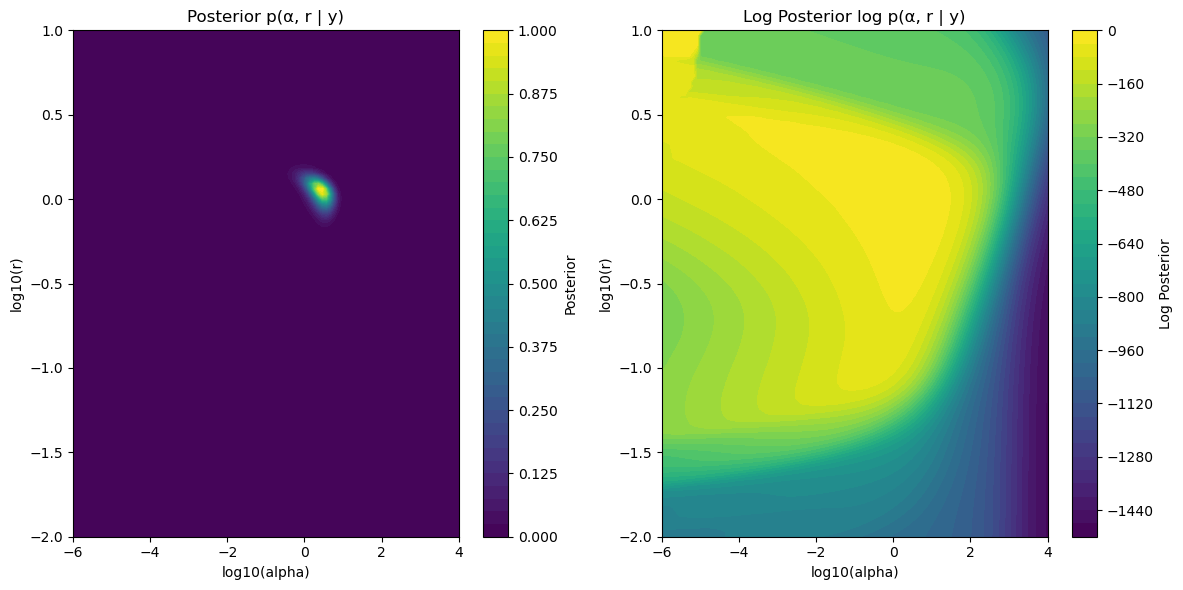

In [19]:
# Output should be the visualisation of p(alpha,r|y) and log p(alpha,r|y) in two separate figures.

#
#### **** YOUR PLOTTING CODE HERE **** ####
plt.figure(figsize=(12, 6))

# Plot p(alpha, r | y)
plt.subplot(1, 2, 1)
plt.contourf(log10_alpha_vals, log10_r_vals, posterior_matrix, levels=40, cmap="viridis")
plt.title("Posterior p(α, r | y)")
plt.xlabel("log10(alpha)")
plt.ylabel("log10(r)")
plt.colorbar(label="Posterior")

# Plot log p(alpha, r | y)
plt.subplot(1, 2, 2)
plt.contourf(log10_alpha_vals, log10_r_vals, log_post_matrix, levels=40, cmap="viridis")
plt.title("Log Posterior log p(α, r | y)")
plt.xlabel("log10(alpha)")
plt.ylabel("log10(r)")
plt.colorbar(label="Log Posterior")

plt.tight_layout()
plt.show()

#

In [20]:
# Add some code to print out
# - the maximum value of log p(alpha, r | y)
# - the corresponding most probable log alpha and log r values
# - the most probable alpha and r values (i.e. 10 ** log alpha etc)

#### **** YOUR CODE HERE **** ####
max_index = np.unravel_index(np.argmax(posterior_matrix), posterior_matrix.shape)

log_alpha_max = log10_alpha_vals[max_index[1]]
log_r_max = log10_r_vals[max_index[0]]

alpha_max = 10 ** log_alpha_max
r_max = 10 ** log_r_max

# Print results
print(f"Maximum value of p(α, r | y): {posterior_matrix[max_index]:.4e}")
print(f"Most probable log10(alpha): {log_alpha_max:.4f}")
print(f"Most probable log10(r): {log_r_max:.4f}")
print(f"Most probable alpha: {alpha_max:.4e}")
print(f"Most probable r: {r_max:.4f}")

Maximum value of p(α, r | y): 1.0000e+00
Most probable log10(alpha): 0.4646
Most probable log10(r): 0.0606
Most probable alpha: 2.9151e+00
Most probable r: 1.1498


# Task 2: Importance Sampling
**8 marks for this task in total.**

This task focuses on implementing the importance sampling algorithm, and then applying it to find an expected value for basis function width $r$.


## Task 2a
*3 marks overall*

#### Write an importance sampler function (2 marks)

Write an importance sampler function. The core sampler should only need around a dozen lines of code, though the implementation of $P^\ast(\alpha, r)$ and proposal $Q(\alpha, r)$ should be external to the sampler (see Task 2b shortly).

It is suggested that the sampler be defined in a general-purpose manner such that $P^\ast(\alpha, r)$ and proposal $Q(\alpha, r)$ are passed as functions. That is, 

    Expectations = importance(num_samples, pstar, qstar, qrvs, fun)
    
where:

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns $P^\ast(\log\alpha, \log r)$
- `qstar` is a function object which takes an array argument `x = [logalpha, logr]` and returns the p.d.f. $Q(\log \alpha,\log r)$
- `qrvs` is a function object which takes no argument, and generates a single sample of both $\log\alpha$ and $\log r$ from $Q(\log\alpha,\log r)$
- `fun` is the function of `x = [logalpha, logr]` to be weighted in the expectation (which will be simply $r$, see the equation in Task 2b which follows)

The sampler should return `Expectations`: an array of `num_samples` expectations as computed for each sample step (you will need to accumulate these values as you go along), the last element of which will be the final expected value of `fun`. Graphing this array will help us assess the convergence of the sampler (Task 2b).

For example, remembering that we are sampling *log* values:

    fun = lambda x: 10**x[1]

and 

    pstar = lambda x: prob_alph_r_given_y(10**x[0], 10**x[1], s2, x_train, y_train, centres)

#### Write your sampler exclusively in terms of logarithmic quantities (advanced) (1 mark)

**Advanced.** Write your sampler such that it can operate in terms of logarithmic p.d.f.s, that is $\log P^\ast(\log\alpha, \log r)$ and $\log Q(\log\alpha, \log r)$. In other words, it should be passed `log_pstar` and `log_qstar` as inputs above, and the relevant importance weights computed inside your function based on those. This would be more numerically robust and preferable in general practice (although won't affect performance in this simple example).



You will get to test out your sampler in Task 2b next.


In [23]:
#### **** YOUR CODE HERE **** ####

# Importance sampler function (with or without the advanced question option)

def importance(num_samples, pstar, qstar, qrvs, fun):
    expectations = np.zeros(num_samples)
    weighted_sum = 0.0
    total_weight = 0.0

    for i in range(num_samples):
        x = qrvs()

        log_P = pstar(x)
        log_Q = qstar(x)

        weight = np.exp(log_P - log_Q)  # Importance weight
        weighted_value = fun(x) * weight

        weighted_sum += weighted_value
        total_weight += weight

        expectations[i] = weighted_sum / total_weight if total_weight > 0 else 0

    return expectations
    #pass


## Task 2b
*3 marks overall*

#### Test the importance sampler on three proposal distributions (3 marks)

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | y)$ investigated above, using importance sampling. Assume that $\sigma^2=0.2^2$ is known. That is, compute (via a sampling approximation):
$$ 
\langle{}r\rangle = \int r . p(\alpha, r | y)\, d\alpha\, dr
$$
We may identify $P^\ast(\alpha, r) = p(y|\alpha, r)$. This assumes a reasonable choice of uniform log priors for $\alpha$ and $r$ meaning we can neglect those terms. Use that as the target distribution for your sampler. 

A key question will be how to define $Q(\log\alpha,\log r)$. You are free to experiment, but in your output below you should **show results for the following three proposal distribution options**:

1. A uniform $Q(\log\alpha,\log r)$, within the full ranges for $\log\alpha$ and $\log r$ suggested for the visualisation of Task 1b above
2. A Gaussian centred at the midpoint of the visualisation, with standard deviation 1/6th of the range in the $\log\alpha$ and $\log r$ directions (*i.e.* one that can reasonably be expected to sample across the entire graph)
3. A Gaussian located at the maximum point you found earlier, $\log\alpha_{\mathrm{MP}}$ and $\log r_{\mathrm{MP}}$, with smaller standard deviation of your choosing (tune this to give more efficient results than 2.) Ideally, your proposal should be broad enough to cover the vast majority of the probability mass of $P^\ast(\alpha, r)$, but no broader.

For each proposal distribution, the sampler should return an array of $K$ expectations, one computed for each sample step, the last element of which will be the final expected $\langle{}r\rangle$. As well as output-ing this expectation, your code should also produce a diagnostic graph (see slides 21&ndash;25, Lecture 7, for examples) to demonstrate suitable convergence (effectively, this is charting `Expectations` as returned from the sampler). When plotting, you may wish to "trim" off the first few (*e.g.* 5) samples, as these can be noisy and upset the vertical auto-scaling.

### Further hints

- For $Q$ and Gaussian proposals over multiple variables, `stats.multivariate_normal` may be useful
- Take care with the handling of the logarithms of $\alpha$ and $r$
- If all goes well, your diagnostic graphs will suggest convergence to a value of $\langle{}r\rangle$ in the region of 1.1 (there will be some natural random variation of this figure)
- 5,000 samples should be adequate, 10,000 ideal, but feel free to experiment



### Reproducibility!

**Important!** As the various sampling algorithms generate random numbers, you should fix your random 'seed' at the outset so that your results are reproducible for individual experiments.

Ideally, you will synchronise your random seeds across both `numpy` and `scipy.stats`. For example:
```python
seed = 1 # Choose your seed as you like!

# This is the old-fashioned way
np.random.seed(seed)
print(stats.uniform.rvs(loc=0, scale=1, size=3))
print(stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1, 0], [0, 1]], size=3))

# This is the "modern" way
rng = np.random.default_rng(seed)
my_gaussian = stats.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
my_gaussian.random_state = rng
print(my_gaussian.rvs(size=3))
print(my_gaussian.rvs(size=3))
# or ...
print(stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1, 0], [0, 1]], size=3, random_state=rng))
```


In [26]:
#### **** YOUR CODE HERE **** ####

# Test the importance sampler

# For each of the three different proposal distributions:
# - chart the convergence of the expectation
# - print out the final expectation <r>

num_samples = 5000  # Adjust this as necessary (e.g. reduce it until your code is bug-free!)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#reproducibility
seed = 2
rng = np.random.default_rng(seed)

#Posterior (target, unnormalized p*)
def log_pstar(x):
    alpha = 10**x[0]
    r = 10**x[1]
    return log_prob_alph_r_given_y(alpha, r, sigma_2, x_train, y_train, centres)
    
#Function to estimate <r>
def fun(x):
    return 10**x[1]

log_alpha_range = [-6, 4]
log_r_range = [-2, 1]


#Uniform Proposal ###
def uniform_qrvs():
    return np.random.uniform([log_alpha_range[0], log_r_range[0]],
                             [log_alpha_range[1], log_r_range[1]])
    
def log_q_uniform(x):
    log_alpha, log_r = x
    if -6 <= log_alpha <= 4 and -2 <= log_r <= 1:
        return -np.log(((4 - (-6)) * (1 - (-2))))
    else:
        return -np.inf


expectations_uniform = importance(num_samples, log_pstar, log_q_uniform, uniform_qrvs, fun)
print(f"Uniform Q <r> estimate: {expectations_uniform[-1]:.4f}")


#Gaussian Proposal at midpoint
mean_midpt = [np.mean(log_alpha_range), np.mean(log_r_range)]
std_dev = [(log_alpha_range[1] - log_alpha_range[0]) / 6.0,
        (log_r_range[1] - log_r_range[0]) / 6.0]
cov_midpt = np.diag(np.square(std_dev))

def log_q_midpt(x):
    return stats.multivariate_normal.logpdf(x, mean = mean_midpt, cov = cov_midpt)

def qrvs_midpt():
    return stats.multivariate_normal.rvs(mean=mean_midpt, cov=cov_midpt, random_state=rng)

expectations_midpt = importance(num_samples, log_pstar, log_q_midpt, qrvs_midpt, fun)
print(f"Gaussian midpoint Q <r> estimate: {expectations_midpt[-1]:.4f}")

#Gaussian at maximum point
log_alpha_peak = 0.0  
log_r_peak = 0.0
mean_peak = [log_alpha_peak, log_r_peak]
cov_peak = np.diag([0.3, 0.3])**2 #finetuned standard deviation

def log_q_peak(x):
    return stats.multivariate_normal.logpdf(x, mean = mean_peak, cov= cov_peak)

def qrvs_peak():
    return stats.multivariate_normal.rvs(mean = mean_peak, cov=cov_peak, random_state=rng)

expectations_peak = importance(num_samples, log_pstar, log_q_peak, qrvs_peak, fun)
print(f"Gaussian max Q <r> estimate: {expectations_peak[-1]:.4f}")

Uniform Q <r> estimate: 1.1085
Gaussian midpoint Q <r> estimate: 1.1292
Gaussian max Q <r> estimate: 1.1125


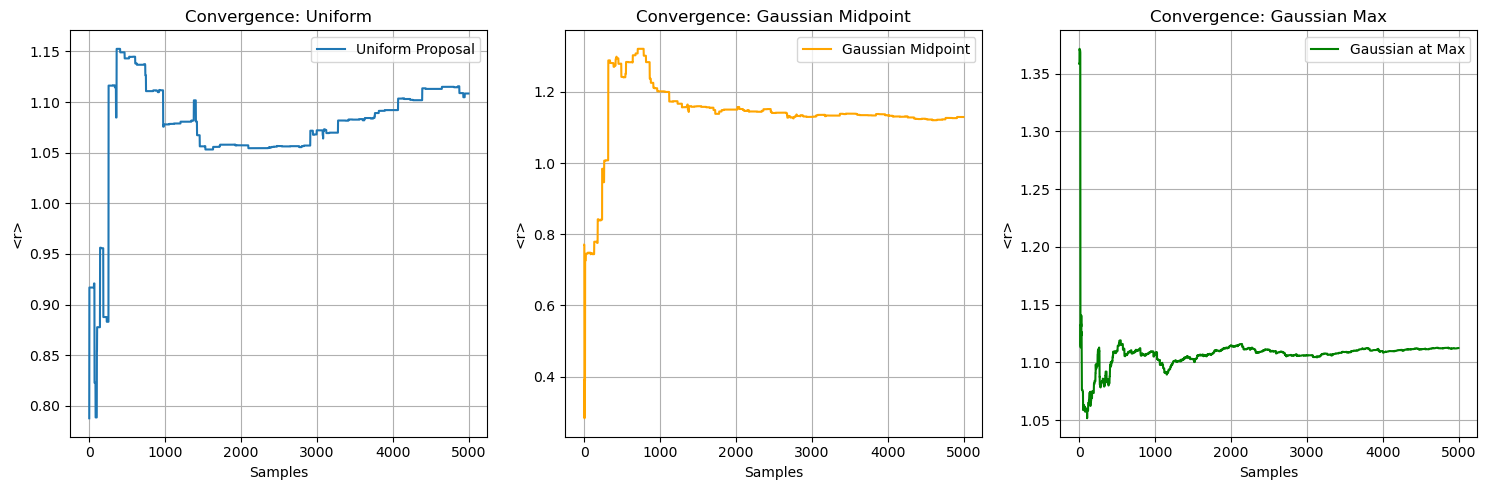

In [27]:
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(15, 5))

# Number of initial samples to trim
burn_in = 5

# Plot for Uniform proposal
plt.subplot(1, 3, 1)
plt.plot(expectations_uniform[burn_in:], label='Uniform Proposal')
plt.title('Convergence: Uniform')
plt.xlabel('Samples')
plt.ylabel('<r>')
plt.grid(True)
plt.legend()

# Plot for Gaussian at midpoint
plt.subplot(1, 3, 2)
plt.plot(expectations_midpt[burn_in:], label='Gaussian Midpoint', color='orange')
plt.title('Convergence: Gaussian Midpoint')
plt.xlabel('Samples')
plt.ylabel('<r>')
plt.grid(True)
plt.legend()

# Plot for Gaussian at peak
plt.subplot(1, 3, 3)
plt.plot(expectations_peak[burn_in:], label='Gaussian at Max', color='green')
plt.title('Convergence: Gaussian Max')
plt.xlabel('Samples')
plt.ylabel('<r>')
plt.grid(True)
plt.legend()

# Display all plots
plt.tight_layout()
plt.show()


##### Task 2c
*2 marks overall*

#### Compare the convergence of the three samplers above by assessing the results over multiple runs (2 marks)

For a given proposal distribution, add functionality (basically, an outer loop around your importance sampler) to compute the variance *at each sample step* of the returned `Expectations` vector over repeated runs of the sampler (**use a different random number seed for each run!**). Repeat for all three proposal distributions of Task 2b, and plot the variance against sample number on the same graph.

If you have done this correctly, you should see all three variances tend to zero over time (2,000 samples roughly). Furthermore, the variance of the tuned Gaussian located at $\log\alpha_{\mathrm{MP}}$ and $\log r_{\mathrm{MP}}$ (Task 2b, proposal 3) should decrease a little more rapidly than the broad Gaussian centred at the midpoint of the visualisation (proposal 2), and both of these should be substantially better than the uniform (proposal 1).

100 repetitions should suffice to obtain convincing results, though as that takes a little while to run (two minutes maybe?), you will probably want to develop and test your solution on a smaller number to begin with.

To save time, it is not necessary to run for 5,000 samples in order to see the trend: 1,000 should suffice. (Although, use 2,000 samples for your final submission when you are confident that everything is working.)


In [29]:
#### **** YOUR CODE HERE **** ####

# Importance sampler proposal convergence comparison

# Output should be a graph showing the variance of the Expectations
# against sample number, as computed over multiple repetitions,
# with all three proposals on the same axis.
num_samples = 1000  # Number of samples per run
num_repetitions = 100  # Number of repetitions for averaging

import numpy as np

expectations_uniform_runs = np.zeros((num_repetitions, num_samples))
expectations_mid_runs = np.zeros((num_repetitions, num_samples))
expectations_peak_runs = np.zeros((num_repetitions, num_samples))

for rep in range(num_repetitions):
    seed = rep
    rng = np.random.default_rng(seed)

    # Uniform Proposal
    def uniform_qrvs():
        return rng.uniform([log_alpha_range[0], log_r_range[0]],
                           [log_alpha_range[1], log_r_range[1]])

    # Gaussian at midpoint
    def qrvs_center():
        return stats.multivariate_normal.rvs(mean=mean_center, cov=cov_center, random_state=rng)

    # Gaussian at MAP estimate
    def qrvs_max():
        return stats.multivariate_normal.rvs(mean=max_mean, cov=max_cov, random_state=rng)

    expectations_uniform_runs[rep] = importance(num_samples, log_pstar, log_q_uniform, uniform_qrvs, fun)
    expectations_mid_runs[rep] = importance(num_samples, log_pstar, log_q_midpt, qrvs_midpt, fun)
    expectations_peak_runs[rep] = importance(num_samples, log_pstar, log_q_peak, qrvs_peak, fun)

variance_uniform = np.var(expectations_uniform_runs, axis=0)
variance_mid = np.var(expectations_mid_runs, axis=0)
variance_max = np.var(expectations_peak_runs, axis=0)

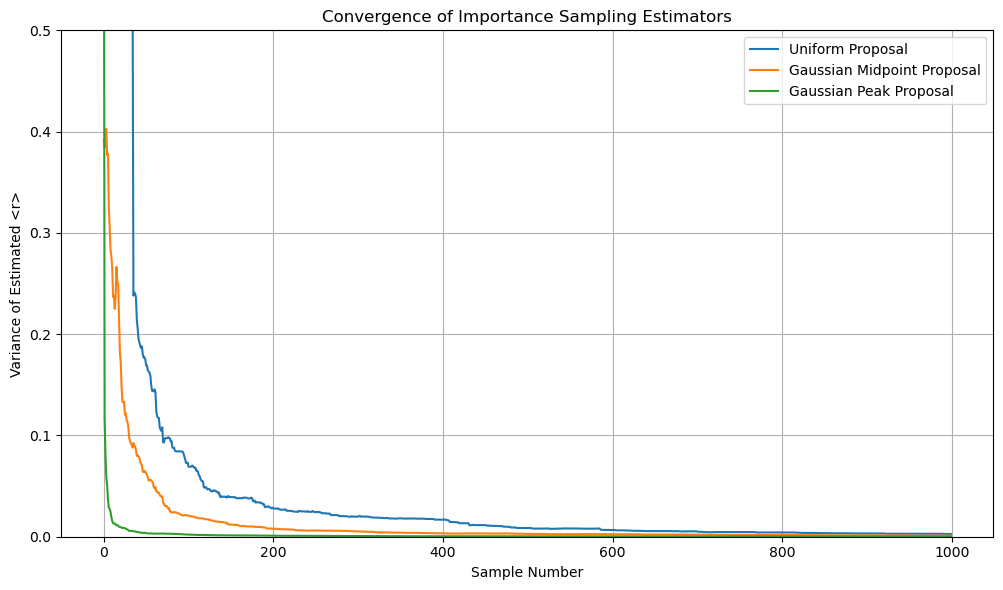

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(variance_uniform, label='Uniform Proposal')
plt.plot(variance_mid, label='Gaussian Midpoint Proposal')
plt.plot(variance_max, label='Gaussian Peak Proposal')
plt.xlabel('Sample Number')
plt.ylabel('Variance of Estimated <r>')
plt.title('Convergence of Importance Sampling Estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.5) 
plt.show()


# Task 3: MCMC & The Metropolis Algorithm
**12 marks for this task in total.**

This task focuses on implementing the Metropolis, MCMC sampling, algorithm, and again applying the sampler to find the expected value for basis function width $r$. This is also extended to estimation of the noise variance $\sigma^2$ and (advanced task) the weights $\mathbf{w}$.

## Task 3a
*2 marks overall*

#### Implement the Metropolis algorithm (2 marks)

It is suggested that the algorithm be implemented as:

    samples, rejected = metropolis(num_samples, pstar, qrvs, x0)

- `num_samples` is the number of samples desired
- `pstar` is a function object which takes an array argument `x` and returns the corresponding $P^\ast(x)$, for example where `x = [log alpha, log r]`
- `qrvs` is a function object which takes a single argument `x` (current state), and generates a single proposal `xdash` sampled from $Q(x'|x)$
- `x0` is the starting state (experiment!), and should be included as the first element of the `samples`

Overall, the Metropolis implementation should need no more than 20 lines of code, and should return a matrix `samples` containing all the sample vectors (states), along with a matrix `rejected` containing all the proposed states that were *rejected*.

Similar to the importance case, the functions `pstar` and `qrvs` will be defined outside your main functon (in Task 3b next).

**Reminder:** as can be seen in the algorithm specification in the slides (but which is easy to forget!), when a proposal is rejected in the Metropolis algorithm, the current state must be *repeated* within the returned samples list.

In [33]:
# Metropolis algorithm (fixed from Task 3a)
def metropolis(num_samples, log_pstar, qrvs, x0):
    samples = [np.array(x0)]
    rejected = []
    current = np.array(x0)
    
    for _ in range(num_samples - 1):
        proposal = np.array(qrvs(current))
        accept_prob = np.exp(min(0, log_pstar(proposal) - log_pstar(current)))

        
        if np.random.random() < accept_prob:
            current = proposal
        else:
            rejected.append(proposal)
        
        samples.append(current)
    
    rejected = np.array(rejected if rejected else [[0, 0]])
    return np.array(samples), rejected


## Task 3b
*7 marks overall*

#### Apply the Metropolis sampler to compute $\langle{}r\rangle$ again (2 marks)

**Remember to fix your random seeds to make your experiments reproducible.**

Calculate the expected value of $\langle{}r\rangle$ under the posterior $p(\alpha, r | y)$ investigated above, using MCMC sampling as implemented by your Metropolis algorithm. Assume that $\sigma^2=0.2^2$ is known. The overall setup should be exactly the same as for the importance sampler, but with a different sampling algorithm. As you may realise, you can re-use the same `pstar` function, although you will need to change `qstar` and create a new `qrvs` to reflect the change in algorithm.

You should use a multivariate Gaussian for $Q$, but experiment with three different length scales (standard deviations):

1. one that is too narrow, which has a very high acceptance rate (anything over 80%), and which "random walks"
2. one too broad, which has a low acceptance rate (say, around 5%)
3. one "just right", with acceptance rate between 20% and 30% (see below hint)

Some degree of "trial and error" is to be expected.

#### Tabulate your results (1 mark)

Once run, produce a tabulation which includes:
- length scale of $Q$
- acceptance rate, which if you have coded it conventionally, should be `(num_samples-len(rejected)) / num_samples`
- the final value of $\langle r \rangle$

#### Visualise the samples (2 marks)

Having run your sampler, for each proposal you should re-create the earlier visualisation of $p(\alpha, r | y)$, with the following additions:
- overlay all the accepted samples in some contrasting colour
- include the rejected proposals too (in a less obvious colour, *e.g.* grey)
- it is suggested you also include the "burn in" samples here (but exclude them when calculating $\langle r\rangle$ - see note below)

#### Plot some diagnostics (2 marks)

For every choice of $Q$ distribution, plot the following:
- the usual graph showing convergence of the $r$ estimate. That is, a graph of $\langle r\rangle$ with increasing time (sample number), exactly as done in Task 2b,
- a histogram of the accepted samples of $r$, with a kernel density estimate (KDE) overlayed (it is suggested you use `seaborn.histplot`). **Throw away the "burn-in" samples for this plot.**

The latter plot will mirror the one we will obtain using the `arviz` library in Coursework 2B shortly.

### Hints

- You should be able to re-use quite a bit of earlier code for some of the above
- Remember that the proposal depends on the current state, unlike the importance sampler. *e.g.* `qrvs = lambda x: stats.multivariate_normal.rvs(size=1, mean=x, cov=[scale, scale])`
- `pstar` can be re-used from earlier (though it will need to be changed for Tasks 3c and 3d)
- To compute $\langle r\rangle$ at each sample step, you will need to average the samples up to that step. For every step this can be done in one line of *Python* making use of `np.cumsum`
- Don't forget your samples will be of $\log r$ (along with $\log\alpha$)
- To accommodate "burn in", it is suggested to throw away the first 5% of samples, then average the rest (but don't sub-sample)
- It might be illuminating to initialise `x0` at random (within the $\log\alpha, \log r$ grid), or even deliberately badly
- For the purposes of your final visualisations, initialise at some distance from the maximum, such as $\log\alpha=-4$ and $\log r=-1.5$
- A total of 10,000 samples should run in a few seconds, although to save time, you will probably want to use fewer when assessing the length scales (1,000 is fine there). If you're limited for computation, using 5,000 samples is fine
- There is some analysis to suggest that the "ideal" acceptance rate is around 23%
- A high rejection rate means inefficiency and many wasted samples, but too low a rate probably indicates "random walking". You should be able to clearly see this on your visualisation.


In [35]:
# Task 3b

# Apply the Metropolis sampler to compute <r>

#### **** YOUR CODE HERE **** ####
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd

# Set reproducibility seed
seed = 2
rng = np.random.default_rng(seed)


# Define the proposal distribution (qrvs) function
def make_qrvs(scale):
    cov = np.array([[scale**2, 0], [0, scale**2]])  # Diagonal covariance
    return lambda x: multivariate_normal.rvs(mean=x, cov=cov, random_state=rng)

# Length scales for the proposal distribution
qrvs_narrow = make_qrvs(0.01)  # Narrow (expect >80% acceptance)
qrvs_wide = make_qrvs(0.7)     # Wide (expect ~5% acceptance)
qrvs_good = make_qrvs(0.2)     # Good (expect 20–30% acceptance)

# Initial state (log_alpha, log_r)
x0 = np.array([-4, -1.5])

# Number of samples
num_samples = 10000

# Run Metropolis for each proposal
samples_narrow, rejected_narrow = metropolis(num_samples, log_pstar, qrvs_narrow, x0)
samples_wide, rejected_wide = metropolis(num_samples, log_pstar, qrvs_wide, x0)
samples_good, rejected_good = metropolis(num_samples, log_pstar, qrvs_good, x0)

# Compute acceptance rate
def compute_acceptance_rate(num_samples, rejected):
    num_rejected = len(rejected) if rejected.shape[0] > 1 or rejected[0, 0] != 0 else 0
    return (num_samples - num_rejected) / num_samples

# Burn-in: discard first 5% of samples
burn_in_percentage = 0.05
burn_in_samples = int(num_samples * burn_in_percentage)

# Compute expected r after burn-in
def compute_final_r(samples, burn_in_samples):
    samples = samples[burn_in_samples:]  # Exclude burn-in
    r_values = 10**samples[:, 1]  # Transform log r to r
    return np.mean(r_values)

# Calculate results
acceptance_rate_narrow = compute_acceptance_rate(num_samples, rejected_narrow)
acceptance_rate_wide = compute_acceptance_rate(num_samples, rejected_wide)
acceptance_rate_good = compute_acceptance_rate(num_samples, rejected_good)

final_r_narrow = compute_final_r(samples_narrow, burn_in_samples)
final_r_wide = compute_final_r(samples_wide, burn_in_samples)
final_r_good = compute_final_r(samples_good, burn_in_samples)

# Tabulate results
results = {
    'Q Length Scale': ['0.01 (Narrow)', '0.5 (Wide)', '0.2 (Good)'],
    'Acceptance Rate': [f'{acceptance_rate_narrow:.3f}', f'{acceptance_rate_wide:.3f}', f'{acceptance_rate_good:.3f}'],
    'Final <r>': [f'{final_r_narrow:.4f}', f'{final_r_wide:.4f}', f'{final_r_good:.4f}']
}

results_df = pd.DataFrame(results)
print("\nResults Table:")
print(results_df)



Results Table:
  Q Length Scale Acceptance Rate Final <r>
0  0.01 (Narrow)           0.902    0.8743
1     0.5 (Wide)           0.048    1.1224
2     0.2 (Good)           0.273    1.1092


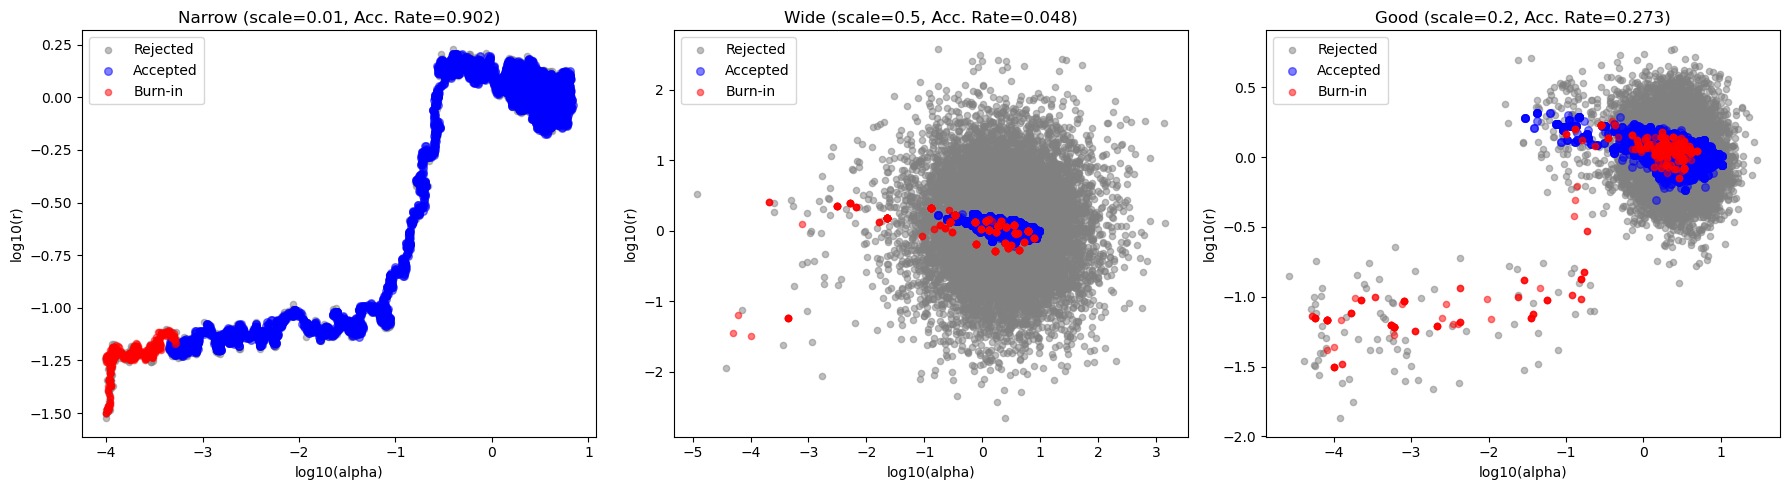

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
burn_in_percentage = 0.05
num_samples = 10000
burn_in_samples = int(num_samples * burn_in_percentage)

# Create three subplots
plt.figure(figsize=(18, 5))

samples_list = [samples_narrow, samples_wide, samples_good]
rejected_list = [rejected_narrow, rejected_wide, rejected_good]
acceptance_rates = [acceptance_rate_narrow, acceptance_rate_wide, acceptance_rate_good]
titles = [
    f'Narrow (scale=0.01, Acc. Rate={acceptance_rates[0]:.3f})',
    f'Wide (scale=0.5, Acc. Rate={acceptance_rates[1]:.3f})',
    f'Good (scale=0.2, Acc. Rate={acceptance_rates[2]:.3f})'
]

for idx, (samples, rejected, title) in enumerate(zip(samples_list, rejected_list, titles)):
    plt.subplot(1, 3, idx + 1)
    
    # Plot rejected proposals
    if rejected.shape[0] > 1 or not np.all(rejected == [0, 0]):
        plt.scatter(rejected[:, 0], rejected[:, 1], color='grey', alpha=0.5, s=20, label='Rejected')

    # Plot accepted samples (after burn-in)
    plt.scatter(samples[burn_in_samples:, 0], samples[burn_in_samples:, 1], color='blue', alpha=0.5, s=30, label='Accepted')
    
    # Plot burn-in samples
    plt.scatter(samples[:burn_in_samples, 0], samples[:burn_in_samples, 1], color='red', alpha=0.5, s=20, label='Burn-in')

    plt.title(title)
    plt.xlabel('log10(alpha)')
    plt.ylabel('log10(r)')
    plt.legend()

plt.tight_layout()
plt.show()


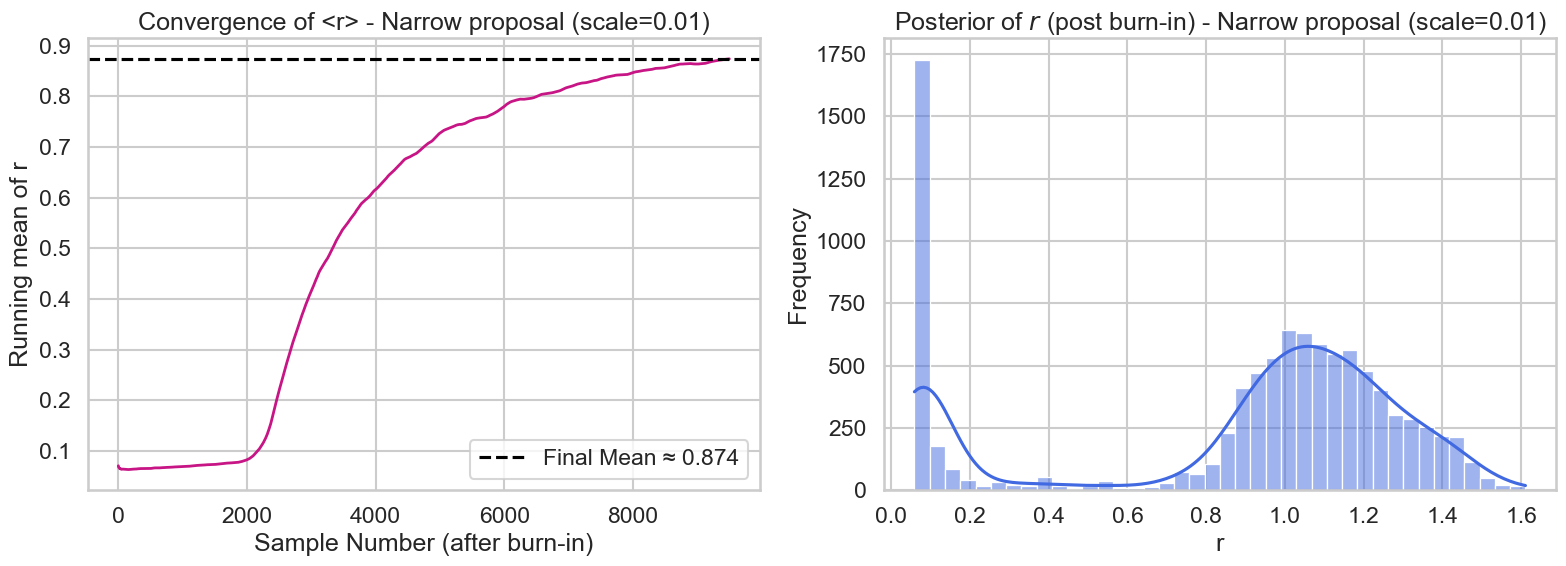

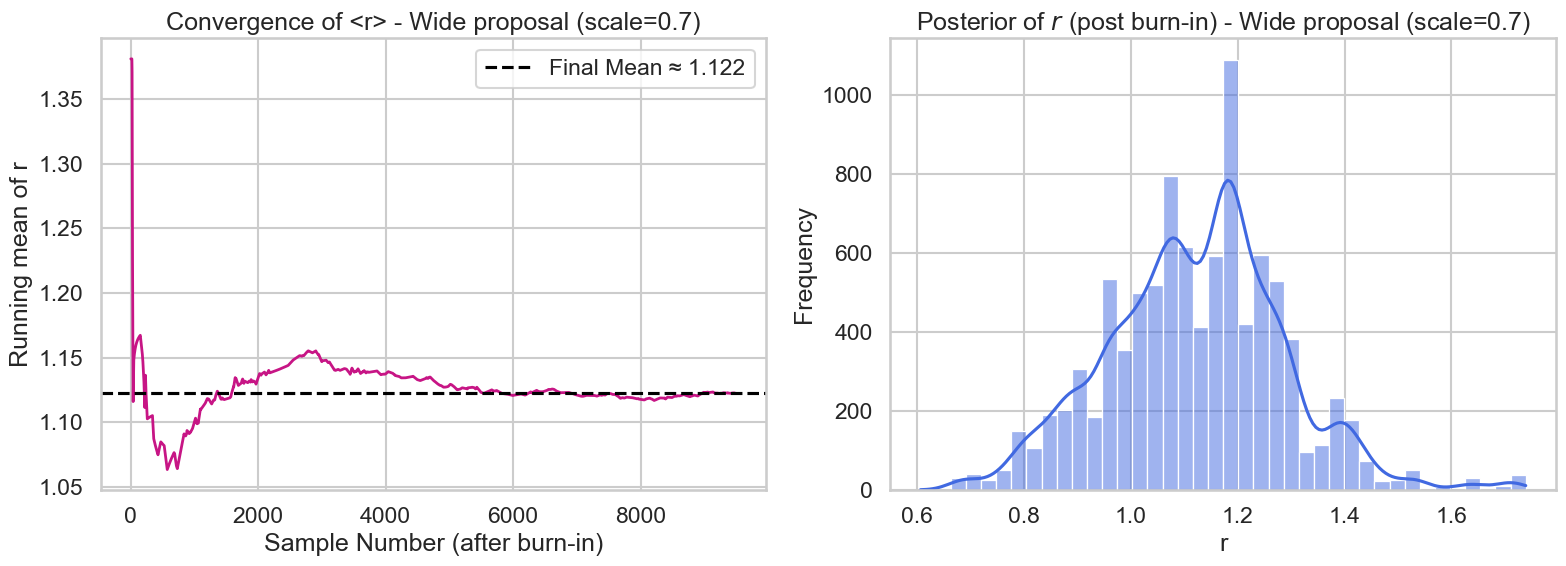

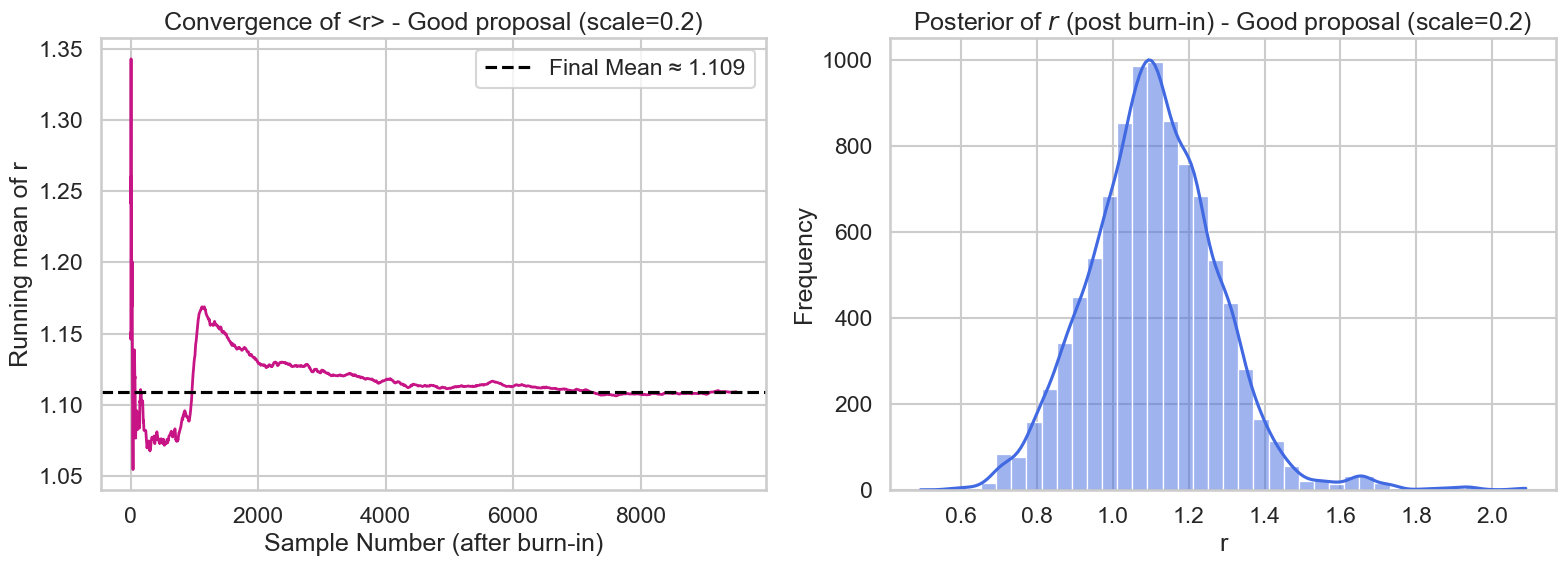

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prettier style
sns.set_style("whitegrid")
sns.set_context("talk")

# Function to compute running mean of r
def compute_running_mean_r(samples):
    r_values = 10 ** samples[:, 1]  # Convert log10(r) to r
    running_sum = np.cumsum(r_values)
    running_mean = running_sum / np.arange(1, len(running_sum) + 1)
    return running_mean, r_values

# Function to plot diagnostics
def plot_diagnostics(samples, title):
    # Discard burn-in
    samples_after_burnin = samples[burn_in_samples:]
    
    # Running mean and r values
    running_mean_r, r_values = compute_running_mean_r(samples_after_burnin)
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot running mean
    axs[0].plot(running_mean_r, color='mediumvioletred', lw=2)
    axs[0].set_xlabel('Sample Number (after burn-in)')
    axs[0].set_ylabel('Running mean of r')
    axs[0].set_title(f'Convergence of <r> - {title}')
    axs[0].axhline(np.mean(r_values), color='black', linestyle='--', label=f'Final Mean ≈ {np.mean(r_values):.3f}')
    axs[0].legend()
    axs[0].grid(True)

    # Plot histogram with KDE
    sns.histplot(r_values, kde=True, ax=axs[1], color='royalblue', bins=40)
    axs[1].set_xlabel('r')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Posterior of $r$ (post burn-in) - {title}')

    plt.tight_layout()
    plt.show()

# Now apply it to all three samplers:
plot_diagnostics(samples_narrow, 'Narrow proposal (scale=0.01)')
plot_diagnostics(samples_wide, 'Wide proposal (scale=0.7)')
plot_diagnostics(samples_good, 'Good proposal (scale=0.2)')


## Task 3c
*1 mark overall*

#### Extend your Metropolis sampler to estimate the noise level $\sigma$ (1 mark)

Extend the above example to include the noise standard deviation $\sigma$. Assume a uniform log prior as usual, and sample in $\log \sigma$ space. Depending on how you have coded up your sample and proposal functions, this could be a very straightforward task. (You will need to adapt the earlier `pstar` function at this point.)

For this task, you only need to consider a "just right" proposal length scale, which you should find through experiment.

For the output of this task, show the two "diagnostic" graphs as in Task 3b.

- the usual graph showing convergence of the $\sigma$ estimate. That is, a graph of $\langle \sigma \rangle$ with increasing time (sample number),
- a histogram of the accepted samples of $\log\sigma$, with a kernel density estimate (KDE) overlayed (it is suggested you use `seaborn.histplot` again). As above, throw away the "burn-in" samples for this plot.

Also print out the final expectation value (which should be not far from the true value of 0.2).

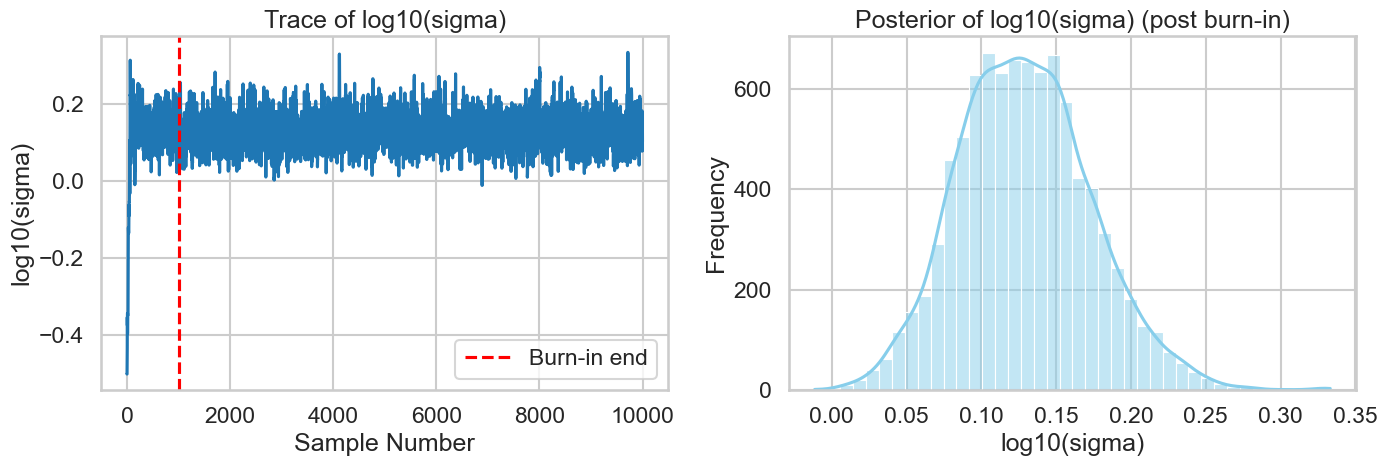

Final estimate of sigma: 1.353


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

# Starting point
x0 = np.array([-4, -1, -0.5])  # (log10(alpha), log10(r), log10(sigma))

# 1. Define log_pstar function (extended)
def log_pstar_extended(x):
    alpha = 10**x[0]  # Convert log(alpha) to alpha
    r = 10**x[1]      # Convert log(r) to r
    sigma = 10**x[2]  # Convert log(sigma) to sigma
    sigma_2 = sigma**2
    
    return log_prob_alph_r_given_y(alpha, r, sigma_2, x_train, y_train, centres)

# 2. Proposal function
def make_qrvs(scale):
    cov = np.diag([scale[0] ** 2, scale[1] ** 2, scale[2] ** 2])
    return lambda x: multivariate_normal.rvs(mean=x, cov=cov)

# 3. Metropolis sampling
#scale = [0.1, 0.1, 0.05]  # Chosen after experiment-- this is giving 0.189
#scale = [0.08, 0.08, 0.02]
scale = [0.07, 0.07, 0.05]
qrvs = make_qrvs(scale)
samples, rejected = metropolis(num_samples, log_pstar_extended, qrvs, x0)

# 4. Diagnostics plotting
def plot_sigma_diagnostics(samples, burn_in_samples):
    log_sigma = samples[:, 2]  # log10(sigma)
    
    # Separate after burn-in
    log_sigma_post_burnin = log_sigma[burn_in_samples:]

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # (a) Trace plot (including burn-in)
    axs[0].plot(log_sigma)
    axs[0].axvline(burn_in_samples, color='red', linestyle='--', label='Burn-in end')
    axs[0].set_xlabel('Sample Number')
    axs[0].set_ylabel('log10(sigma)')
    axs[0].set_title('Trace of log10(sigma)')
    axs[0].legend()
    axs[0].grid(True)

    # (b) Histogram + KDE (after burn-in)
    sns.histplot(log_sigma_post_burnin, kde=True, bins=40, color='skyblue', ax=axs[1])
    axs[1].set_xlabel('log10(sigma)')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Posterior of log10(sigma) (post burn-in)')

    plt.tight_layout()
    plt.show()

# 5. Run the diagnostic plot
burn_in_samples = 1000  # Example: you can adjust based on your chain
plot_sigma_diagnostics(samples, burn_in_samples)

# 6. Final sigma estimate (optional)
sigma_post_burnin = 10 ** samples[burn_in_samples:, 2]
print(f"Final estimate of sigma: {np.mean(sigma_post_burnin):.3f}")


## Task 3d (advanced)
*2 marks overall*

#### Be "strictly Bayesian" and sample all the model unknowns to derive the mean predictor (2 marks)

**Advanced.** Extend your Metropolis algorithm to sample over *all* the unknowns in the model: that is, not just $\alpha$, $\sigma$, $r$ as in Task 3c, but also the weights $\mathbf{w}$. This is slightly artificial, in that we don't really need to sample the weights in this model (the posterior over $\mathbf{w}$ is analytically computable), but it demonstrates the principle. In a neural network model (which will be nonlinear in $\mathbf{w}$), we *will* need to sample.

The objective of this task is to plot the "average" predictor at the points `x_test` (you may re-use `plot_regression` for the actual graphing). The quantity to be found is:

$$
\langle \mathbf{y} \rangle = \int (\mathbf{\Phi_\ast} \mathbf{w}) . p(\mathbf{w}, \alpha, r, \sigma^2 | y)\, d\mathbf{w}\, d\alpha\, dr\, d\sigma^2,
$$
where $\mathbf{\Phi_\ast}$ is the basis matrix evaluated at `x_test` (and depends on $r$).

You will need to set up your Metropolis algorithm to sample from $p(\mathbf{w}, \alpha, r, \sigma^2 | y)$. This is of course given by Bayes' rule:

$$
p(\mathbf{w}, \alpha, r, \sigma^2 | y) = \frac{p(y|\mathbf{w}, r, \sigma^2)\,p(\mathbf{w}| \alpha)\,p(\alpha)\,p(r)\,p(\sigma^2)}{p(y)}.
$$
From this, we can identify
$$
P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(y|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)\, p(\alpha)\,p(r)\, p(\sigma^2)
$$
where

- $p(y|\mathbf{w}, r, \sigma^2)$ is the Gaussian likelihood probability model, with dependence on $r$ made explicit
- $p(\mathbf{w}| \alpha)$ is the Gaussian weight prior 
- $p(\alpha)$, $p(r)$ and $p(\sigma^2)$ are hyperpriors, which if defined as uniform over $\log\alpha$, $\log r$ and $\log\sigma$ respectively, may be considered constant

The state space here will be very high! It is 53-dimensional, due to the 50 weights combined with $\alpha$, $r$ and $\sigma^2$. A relatively narrow Gaussian proposal distribution $Q(\theta^\prime| \theta)$ should work OK, though you may wish to experiment with the length scales. Ideally, you would use different length scales for the different parameter types (that is, one scale for all the weights, and one scale for all the hyper-parameters).

So your approach might be:

- Define $P^\ast(\mathbf{w}, \alpha, r, \sigma^2) = p(y|\mathbf{w}, r, \sigma^2)\, p(\mathbf{w}| \alpha)$ (all other terms in the numerator being constant and therefore unnecessary) and write a function `new_log_pstar(x)` to calculate posterior where `x` is the 53-dimensional state.
- Use this to generate a set of samples of $\mathbf{w}, \alpha, r, \sigma^2$ using your Metropolis algorithm (use 10,000 samples for your final results)
- Suggest you aim for an acceptance rate of around 25% (not precisely critical)
- For each sample, compute the appropriate basis matrix and subsequent predictor
    - `RBF = setup.RBFGenerator(centres, r)` using sampled $r$
    - `PHI_test = RBF.evaluate(x_test)`
    - `y_pred = PHI_test @ w` using sampled $\mathbf{w}$ and giving a 1000-long vector of predictions at the test points
- Average all the `y_pred` vectors to give the overall mean predictor as  `y_pred_mean`
- At the same time, as a sanity check, you might want to compute $\langle \sigma \rangle$ from the same set of samples, which should be in the region of 0.2 (optional, but easy to do). **If the value of $\sigma$ is far from 0.2, it is a useful indication that the sampler is not working well (scales are sub-optimal).**

In summary, for this task:
- Plot the mean predictor as requested above (following the same format as the example graph "Data, Underlying Function and Example Predictor" earlier in this notebook),
- Print out the noise estimate $\langle \sigma \rangle$.

*If you have done this right, you should find that your predictor is a very good fit to the generating function, taking the limitations of the training data into account.*


In [41]:
# 1. Setup
RBF_current = setup.RBFGenerator(centres)  # Create normally
RBF_current.r = 0.5  # Manually set r!
PHI_train_initial = RBF_current.evaluate(x_train)
M_actual = PHI_train_initial.shape[1]  # Number of basis functions

# 2. Define log_pstar function (posterior over [w, log10(alpha), log10(r), log10(sigma)])
def log_pstar_full(x):
    w = x[:M_actual]
    log10_alpha = x[M_actual]
    log10_r = x[M_actual + 1]
    log10_sigma = x[M_actual + 2]

    alpha = 10 ** log10_alpha
    r = 10 ** log10_r
    sigma = 10 ** log10_sigma
    sigma2 = sigma ** 2

    # Build RBF basis with new r
    RBF_current = setup.RBFGenerator(centres)
    RBF_current.r = r  # Set r manually!
    PHI_train_current = RBF_current.evaluate(x_train)

    # Log-likelihood
    residual = y_train - PHI_train_current @ w
    log_likelihood = -0.5 * (np.sum(residual**2) / sigma2 + len(y_train) * np.log(2 * np.pi * sigma2))

    # Log-prior for weights
    log_prior_w = -0.5 * (np.sum(w**2) * alpha + len(w) * np.log(2 * np.pi) - len(w) * np.log(alpha))

    return log_likelihood + log_prior_w

# 3. Proposal function
def make_qrvs_full(scale_w, scale_hyper):
    cov = np.diag(np.concatenate([scale_w * np.ones(M_actual), scale_hyper * np.ones(3)]) ** 2)
    return lambda x: np.random.multivariate_normal(mean=x, cov=cov)

# 4. Initial guess
w0 = np.random.normal(0, 0.01, M_actual)
log10_alpha0 = np.log10(1e-3)
log10_r0 = np.log10(0.5)
log10_sigma0 = np.log10(0.4)
x0_full = np.concatenate([w0, [log10_alpha0, log10_r0, log10_sigma0]])

# 5. Build proposal
scale_w = 0.02
scale_hyper = 0.05
qrvs_full = make_qrvs_full(scale_w, scale_hyper)

# 6. Run MCMC
samples_full, rejected_full = metropolis(num_samples, log_pstar_full, qrvs_full, x0_full)

# 7. Post-process
samples_post_burnin = samples_full[burn_in_samples:]
w_samples = samples_post_burnin[:, :M_actual]
log10_alpha_samples = samples_post_burnin[:, M_actual]
log10_r_samples = samples_post_burnin[:, M_actual + 1]
log10_sigma_samples = samples_post_burnin[:, M_actual + 2]

# Predict on test set
y_preds = []

for i in range(samples_post_burnin.shape[0]):
    w = w_samples[i]
    r = 10 ** log10_r_samples[i]

    RBF_current = setup.RBFGenerator(centres)
    RBF_current.r = r  # Set r manually
    PHI_test_current = RBF_current.evaluate(x_test)

    y_pred = PHI_test_current @ w
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
y_pred_mean = np.mean(y_preds, axis=0)
sigma_mean = np.mean(10 ** log10_sigma_samples)



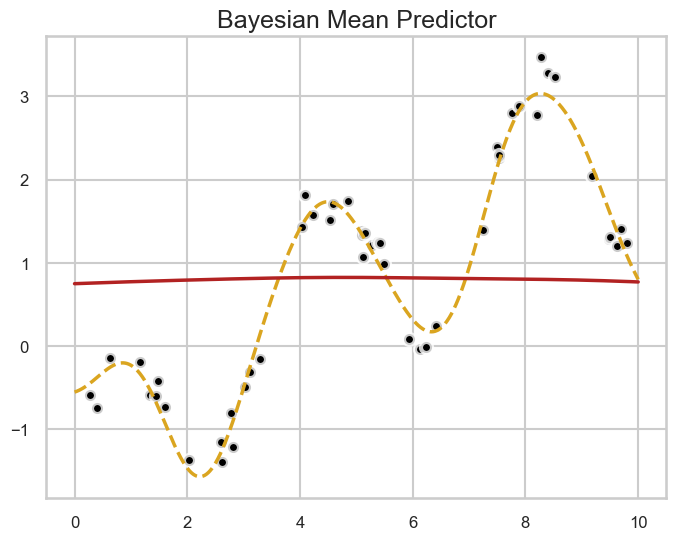

Mean noise sigma estimate: 9.614


In [42]:
# 8. Plot
setup.plot_regression(x_train, y_train, x_test, y_test, y_pred_mean)
plt.title("Bayesian Mean Predictor")
plt.show()

# 9. Print sigma
print(f"Mean noise sigma estimate: {sigma_mean:.3f}")
